# Visualization

In this notebook, we visualize how measurements of interest, for example total tracer mass, evolves over time, with varyin conditions. 

The visualizations are based on the results from the "Simulation Notebook".

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import dolfin
from multirat import *
from pathlib import Path
from dolfin import assemble, dx, Expression, Constant

In [2]:
MESH_DIR = Path("../mesh").resolve()
RESULTS_DIR = Path("../results").resolve()

In [3]:
def get_values(model, resolution, function, hours=np.inf):
    storagepath = Path(f"../results/results-{model}-mesh{res}")
    storage = TimeSeriesStorage("r", storagepath)    
    
    endtime = 3600 * hours
    times = storage.times
    values = np.empty(times.size)

    for idx, (ti, u) in enumerate(storage.dual_iter()):
        if ti > endtime:
            for key in values:
                values = values[:idx]
                times = times[:idx]
            break
        values[idx] = function(u)
    
    if ti < endtime:
        print(f"Simulation stopped after {ti / 3600}h < {endtime / 3600}h requested.")
    
    storage.close()
    
    return times, values

In [4]:
center = parameters.PARAMS["injection_center"]
phi = parameters.PARAMS["porosity_ecs"]

cube2 = characteristic_cube(center, sidelength=2.0)
cube4 = characteristic_cube(center, sidelength=4.0)
cube5 = characteristic_cube(center, sidelength=5.0)

functions = {
    'amount_total': lambda u: assemble(u * dx),
    'amount_cube2': lambda u: assemble(cube2 * u * dx),
    'amount_cube4': lambda u: assemble(cube4 * u * dx),
    'amount_cube5': lambda u: assemble(cube5 * u * dx),
    'concentration_injection': lambda u: u(*center),
}

In [5]:
values = {}
times = {}

resolutions = [8]#, 16, 32, 64]
models = ["homogeneous", "tracerconservation", "tracerdecay"]
hours = 6


for model in models:
    values[model] = {}
    times[model] = {}
    for res in resolutions:
        print(f"Model {model}, resolution {res}")
        values[model][res] = {}
        for funcname, func in functions.items():
            times[model][res], values[model][res][funcname] = get_values(model, res, func, hours)
        print()

Model homogeneous, resolution 8
Simulation stopped after 1.0h < 6.0h requested.
Simulation stopped after 1.0h < 6.0h requested.
Simulation stopped after 1.0h < 6.0h requested.
Simulation stopped after 1.0h < 6.0h requested.
Simulation stopped after 1.0h < 6.0h requested.

Model tracerconservation, resolution 8
Simulation stopped after 1.0h < 6.0h requested.
Simulation stopped after 1.0h < 6.0h requested.
Simulation stopped after 1.0h < 6.0h requested.
Simulation stopped after 1.0h < 6.0h requested.
Simulation stopped after 1.0h < 6.0h requested.

Model tracerdecay, resolution 8
Simulation stopped after 1.0h < 6.0h requested.
Simulation stopped after 1.0h < 6.0h requested.
Simulation stopped after 1.0h < 6.0h requested.
Simulation stopped after 1.0h < 6.0h requested.
Simulation stopped after 1.0h < 6.0h requested.



### Total vs Local Amounts 

In [6]:
def plot_wrapper(time, values, relative=False, ax=None, *args, **kwargs):
    if ax is None:
        fig, ax = plt.subplots()
    
    if relative:
        vals = values / values[0]
    else:
        vals = values

    ax.plot(time / 60, vals, *args, **kwargs)
    ax.set_xlim(0, time[-1] / 60)
    ax.set_xticks(time[::60] / 60)
    ax.set_xlabel("Time (min)", fontsize=16)
    ax.set_ylim(0, None, auto=True)
    return ax

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


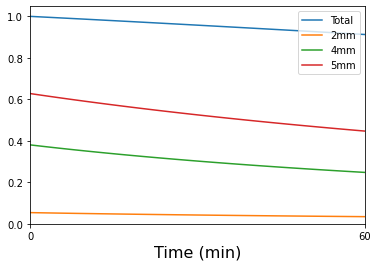

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


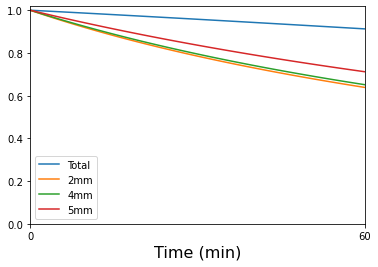

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


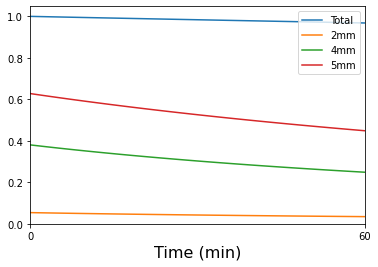

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


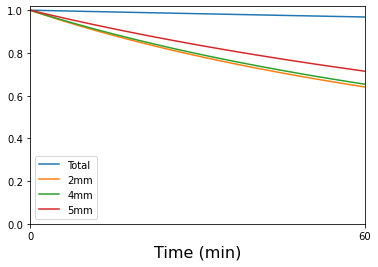

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


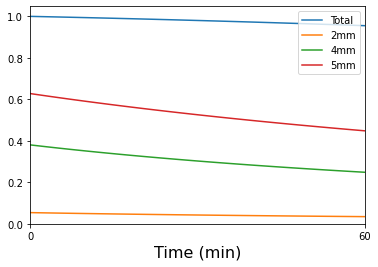

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


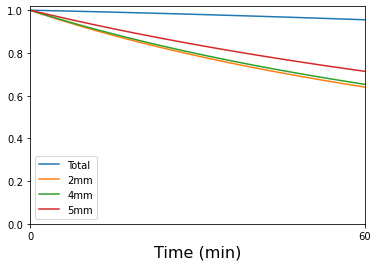

In [7]:
amount_plot_labels = {
    "amount_total": "Total",
    "amount_cube2": "2mm",
    "amount_cube4": "4mm",
    "amount_cube5": "5mm"
}

for model in models:
    res = 8
    time = times[model][res]
    fig, ax = plt.subplots()
    for funcname, funclabel in amount_plot_labels.items():
        plot_wrapper(time, values[model][res][funcname], relative=False, label=funclabel, ax=ax)
    ax.set_ylim(0, None)
    plt.legend()
    plt.savefig(f"{RESULTS_DIR}/figures/inulin-diffusion-amounts-{model}-res{res}-{hours}hours-absolute.png", bbox_inches="tight")
    plt.savefig(f"{RESULTS_DIR}/figures/inulin-diffusion-amounts-{model}-res{res}-{hours}hours-absolute.eps", format='eps', bbox_inches="tight")
    plt.show()
    
    
    fig, ax = plt.subplots()
    for funcname, funclabel in amount_plot_labels.items():
        plot_wrapper(time, values[model][res][funcname], relative=True, label=funclabel, ax=ax)
        
    plt.legend()
    plt.savefig(f"{RESULTS_DIR}/figures/inulin-diffusion-amounts-{model}-res{res}-{hours}hours-relative.png", bbox_inches="tight")
    plt.savefig(f"{RESULTS_DIR}/figures/inulin-diffusion-amounts-{model}-res{res}-{hours}hours-relative.eps", format="eps", bbox_inches="tight")

    plt.show()

## Mesh Refinement Effect

In [8]:
def plot_varying_resolution(funcname, model, resolutions=None):
    if resolutions is None:
        resolutions = [8, 16, 32, 64]
            
    fig, ax = plt.subplots()
    for res in resolutions:
        time = times[model][res]
        plot_wrapper(time, values[model][res][funcname], relative=False, label=f'Res {res}', ax=ax)
    plt.legend()
    plt.savefig(f"../results/figures/inulin-diffusion-resolutions-{model}-{funcname}-{hours}hours-absolute.png", bbox_inches="tight")
    plt.savefig(f"../results/figures/inulin-diffusion-resolutions-{model}-{funcname}-{hours}hours-absolute.eps",  format='eps', bbox_inches="tight")

    plt.show()
    
    
    fig, ax = plt.subplots()
    for res in resolutions:
        time = times[model][res]
        plot_wrapper(time, values[model][res][funcname], relative=True, label=f'Res {res}', ax=ax)#     plt.xlim(0, hours * 60)
    plt.legend()
    plt.savefig(f"../results/figures/inulin-diffusion-resolutions-{model}-{funcname}-{hours}hours-relative.png", bbox_inches="tight")
    plt.savefig(f"../results/figures/inulin-diffusion-resolutions-{model}-{funcname}-{hours}hours-relative.eps", format='eps', bbox_inches="tight")
    plt.show()

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


Model homogeneous
amount_total


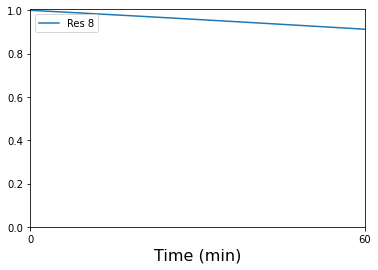

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


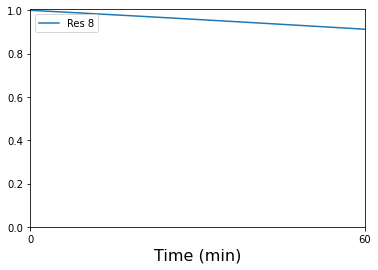

amount_cube2


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


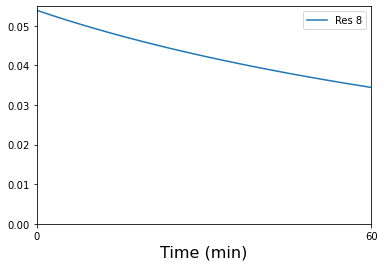

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


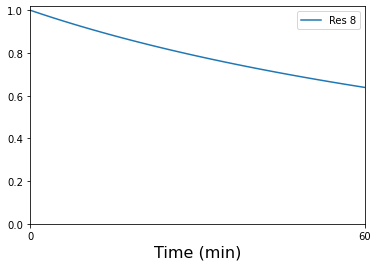

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


concentration_injection


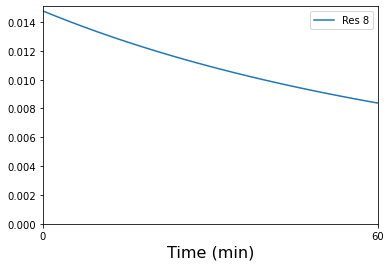

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


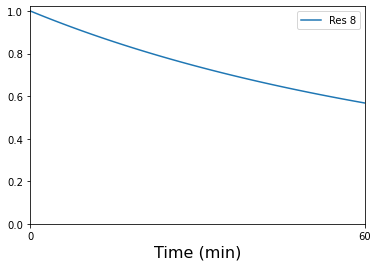

Model tracerconservation
amount_total


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


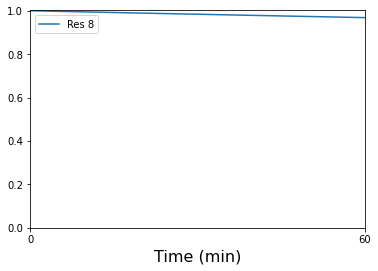

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


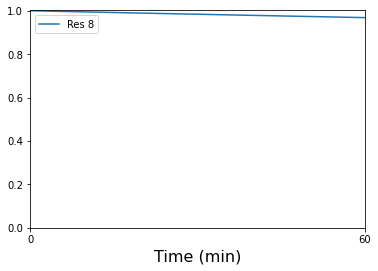

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


amount_cube2


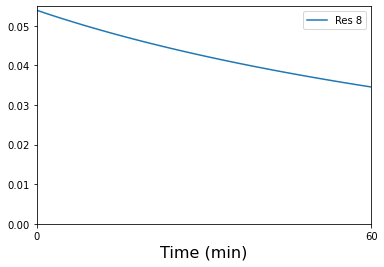

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


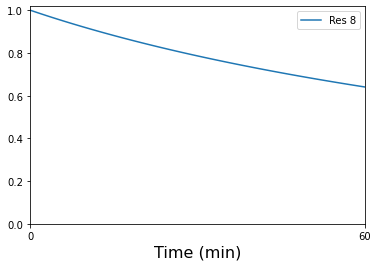

concentration_injection


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


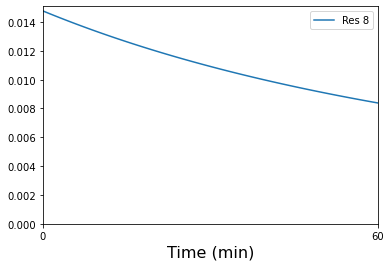

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


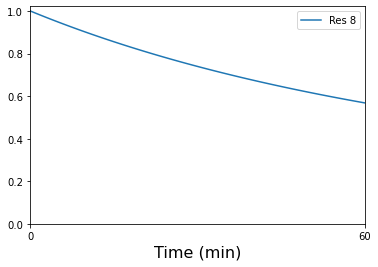

Model tracerdecay
amount_total


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


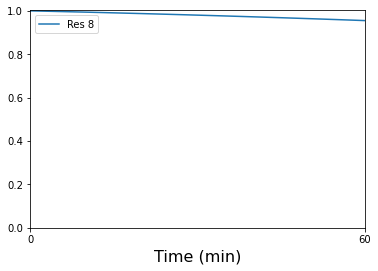

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


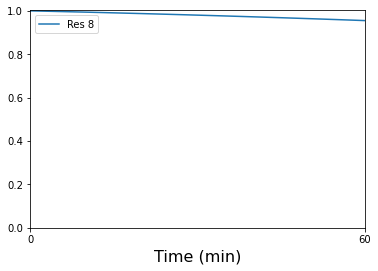

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


amount_cube2


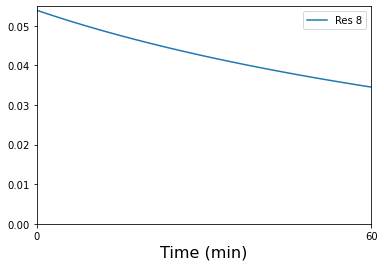

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


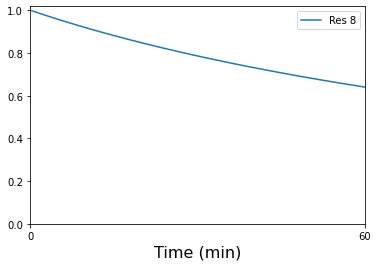

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


concentration_injection


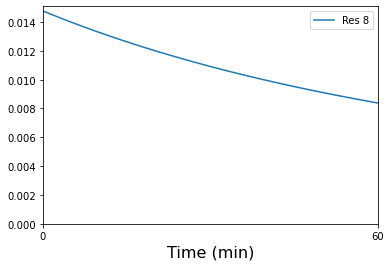

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


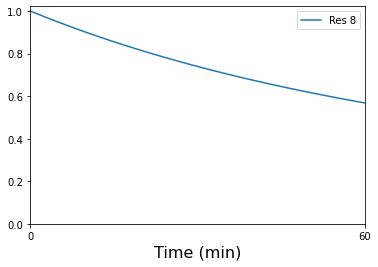

In [9]:
resolutions = [8]
for model in models:
    print("Model", model)
    for func in ["amount_total", "amount_cube2", "concentration_injection"]:
        print(func)
        plot_varying_resolution(func, model, resolutions=resolutions)
    print("=" * 80)

## Model Comparisons 

In [10]:
def plot_different_models(resolution, funcname, models=None):
    if models is None:
        models = {
            "homogeneous": "Homogeneous",
            "tracerconservation": "Tracer Conservation",
            "tracerdecay": "Tracer Decay"
        }
    
    fig, ax = plt.subplots()
    for modelname, model_label in models.items():
        time = times[modelname][res]
        plot_wrapper(time, values[modelname][resolution][funcname], relative=True, label=model_label, ax=ax)
    plt.legend()
#     plt.ylabel("$N(t)\,/\,N_0 $", fontsize=16)
#     plt.ylabel("Relative Mass", fontsize=16)
    plt.savefig(f"{RESULTS_DIR}/figures/inulin-diffusion-models-res{res}-{funcname}-{hours}hours-relative.eps", format="eps", bbox_inches="tight")
    plt.savefig(f"{RESULTS_DIR}/figures/inulin-diffusion-models-res{res}-{funcname}-{hours}hours-relative.png", bbox_inches="tight")
    plt.show()
    
    fig, ax = plt.subplots()
    for modelname, model_label in models.items():
        time = times[modelname][res]
        plot_wrapper(time, values[modelname][resolution][funcname], relative=False, label=model_label, ax=ax)
    plt.legend()
#     plt.ylabel("$N(t)\,/\,N_0 $", fontsize=16)
#     plt.ylabel("Amount", fontsize=16)
    plt.savefig(f"{RESULTS_DIR}/figures/inulin-diffusion-models-res{res}-{funcname}-{hours}hours-absolute.eps", format="eps", bbox_inches="tight")
    plt.savefig(f"{RESULTS_DIR}/figures/inulin-diffusion-models-res{res}-{funcname}-{hours}hours-absolute.png", bbox_inches="tight")
    plt.show()

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


Function amount_total


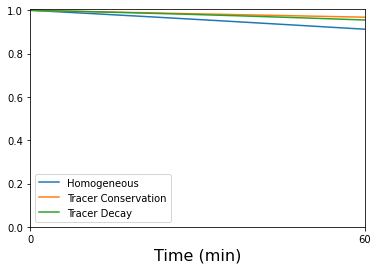

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


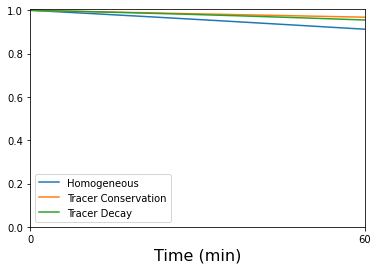

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.



Function amount_cube2


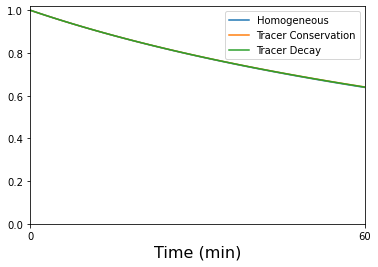

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


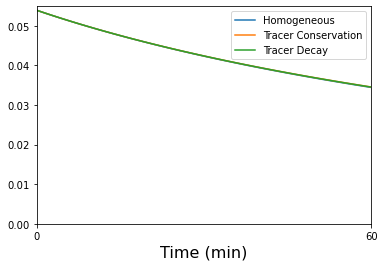

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.



Function amount_cube4


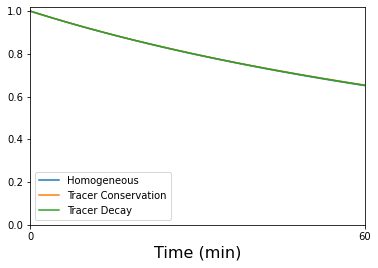

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


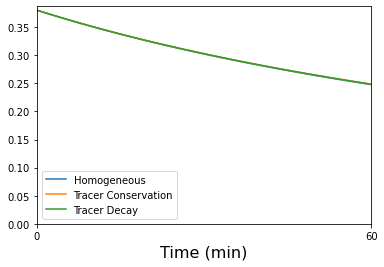

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.



Function amount_cube5


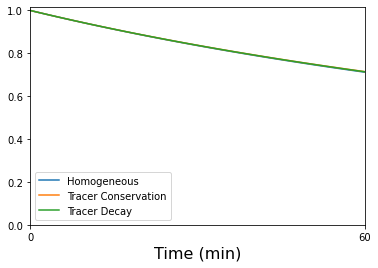

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


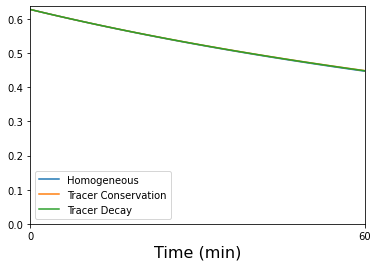

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.



Function concentration_injection


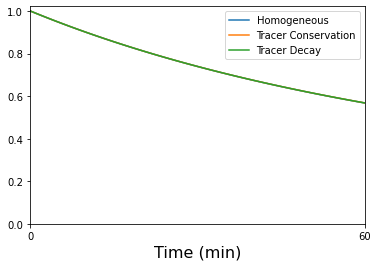

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


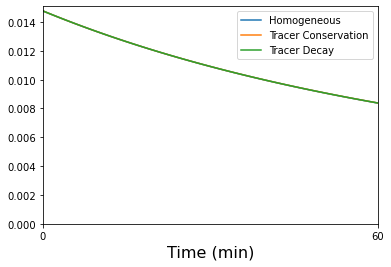

In [11]:
res = 8

for func in ["amount_total", "amount_cube2", "amount_cube4", "amount_cube5", "concentration_injection"]:
    print("Function", func)
    plot_different_models(res, func)
    print("=" * 80)
    print()